# Recommendation System

**PROBLEM STATEMENT**

Over the past two decades, there has been a monumental shift in how people 
access and consume video content. With universal access to broadband
internet, numerous platforms like YouTube, Netflix, HBO Go emerged and 
steadily grew to prominence.
Although not a household name, OTT is the exact technology that made the 
streaming revolution possible.
OTT stands for Over the Top, refers to any video streaming service delivering
content to the users over the internet, however there are subscription charges
associated with the usage of such platforms such as Prime Video, Netflix, Hot 
Start, Zee5, Sony Liv etc.
But choosing your next movie to watch can still be a daunting task, even if you
have access to all the platforms.
“MyNextMovie” is a budding startup in the space of recommendations on top
of various OTT platforms providing suggestions to its customer base regarding 
their next movie.
Their major business is to create a recommendation layer on top of these OTT 
platforms so that they can make suitable recommendations to their customers,
However,since they are in research mode right now, they would want to
experiment with open source data first to understand the depth of the models
which can be delivered by them.
The data for this exercise is open-source data which has been collected and
made available from the MovieLens web site (http://movielens.org), a part of
GroupLens
Research The data sets were collected over various periods of time, depending
on the size of the set

**OBJECTIVES**

1. Create a popularity based recommender system at a genre level. User will input a genre (g), minimum ratings threshold (t) for a movie and no. of recommendations(N) for which it should be recommended top N movies which are most popular within that genre (g) ordered by ratings in descending order where each movie has at least (t) reviews.
2. Create a content-based recommender system which recommends top N movies based on similar movie(m) genres.
3. Create a collaborative based recommender system which recommends top N movies based on “K” similar users for a target user “u”



**DATA DESCRIPTION**

The data consists of 105339 ratings applied to over 10329 movies. The average
rating is 3.5 and minimum and maximum rating is 0.5 and 5 respectively. There
are 668 users who have given their ratings for 149532 movies.
There are two data files which are provided:
- **Movies.csv:**
    - movieId: ID assigned to a movie.
        title: Title of a movie
        genres: pipe separated list of movie genres.
- Ratings.csv
    - userId: ID assigned to a user
        movieId: ID assigned to a movie
        rating: rating by a user to a movie
        Timestamp: time at which the rating was provided.

## Importing necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

import regex as re

import warnings
warnings.filterwarnings('ignore')
sns.set_style('white')
%matplotlib inline

## Loading the dataset

In [2]:
movies_df = pd.read_csv('movies_project.csv')
ratings_df = pd.read_csv('ratings_project.csv')

In [3]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


## Data Exploration

In [5]:
# total ratings
n_ratings = len(ratings_df)

# number of unique movies
n_movies = movies_df.movieId.nunique()

# number of unique users 
n_users = ratings_df.userId.nunique()

# average rating per user
avg_rating_per_user = round(n_ratings / n_users, 2)

# average rating per movie
avg_rating_per_movie = round(n_ratings / n_movies, 2)
unique_ratings = sorted(ratings_df.rating.unique())

print(f"Number of ratings:, {n_ratings}")
print(f"Number of unique users: {n_users}")
print(f'Number of unique movies: {n_movies}')
print(f"Average number of rating per user: {avg_rating_per_user}")
print(f'Average number of rating per movie: {avg_rating_per_movie}')
print(f"The total unique rating: {ratings_df.rating.nunique()}")
print(f"Unique Ratings: {unique_ratings}")

Number of ratings:, 105339
Number of unique users: 668
Number of unique movies: 10329
Average number of rating per user: 157.69
Average number of rating per movie: 10.2
The total unique rating: 10
Unique Ratings: [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [6]:
print('shape of movie dataset:', movies_df.shape)
print('shape of ratings dataset:', ratings_df.shape)

shape of movie dataset: (10329, 3)
shape of ratings dataset: (105339, 4)


## checking for missing values and duplicates

In [7]:

movies_df.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [8]:
ratings_df.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [9]:
movies_df.duplicated(subset=['movieId', 'title']).sum()

0

In [10]:
ratings_df.duplicated(subset=['userId', 'movieId', 'rating']).sum()

0

There are no missing values nor duplicated rows in both datasets

In [11]:
count_ratings = ratings_df.groupby('movieId')['rating'].aggregate(['mean', 'count'])
count_ratings.reset_index(inplace=True)
count_ratings.columns = ['movieId', 'mean_rating', 'num_of_ratings']

In [12]:
count_ratings

,movieId,mean_rating,num_of_ratings
0,1,3.907328,232
1,2,3.353261,92
2,3,3.189655,58
3,4,2.818182,11
4,5,3.250000,62
...,...,...,...
10320,146684,4.000000,1
10321,146878,2.500000,1
10322,148238,3.000000,1
10323,148626,4.333333,3


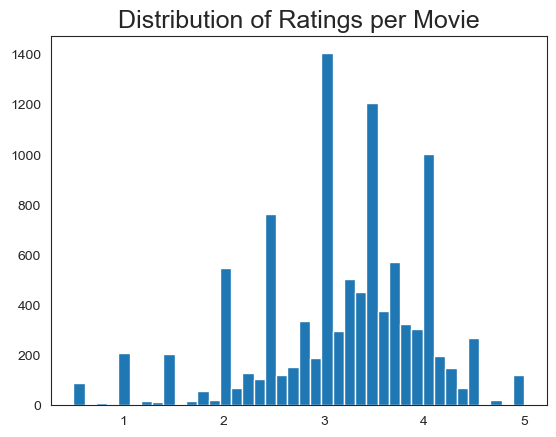

In [13]:
# The distribution of the mean_rating per movie
plt.hist(count_ratings['mean_rating'], bins=40)
plt.title('Distribution of Ratings per Movie', fontsize=18)
plt.show()

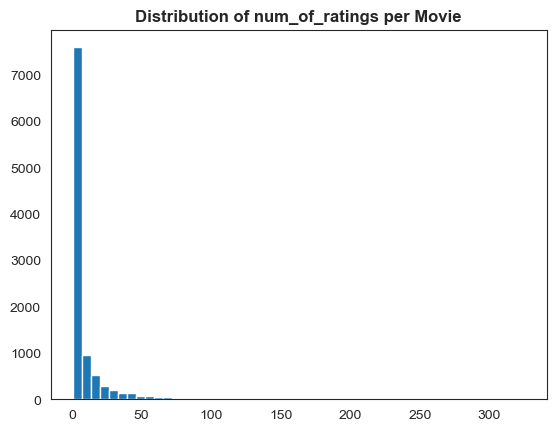

In [14]:
# The distribution of number ratings per movie
plt.hist(count_ratings.num_of_ratings, bins=50)
plt.title('Distribution of num_of_ratings per Movie', weight='bold')
plt.show()

<Figure size 1000x1000 with 0 Axes>

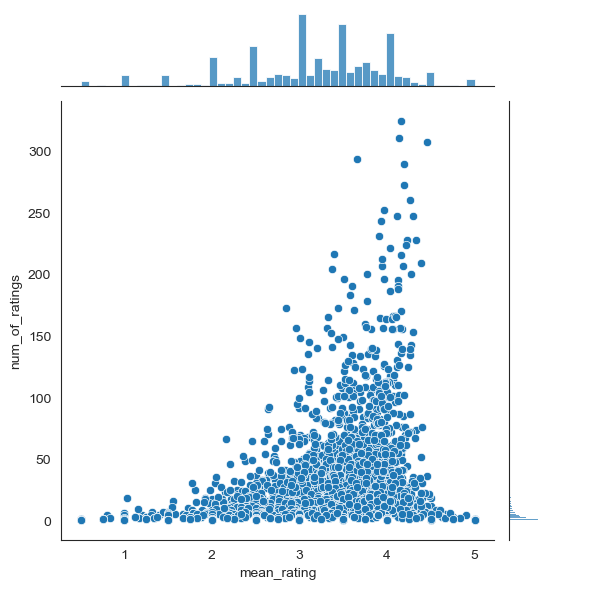

In [15]:
plt.figure(figsize=(10,10))
sns.jointplot(data=count_ratings, x='mean_rating', y='num_of_ratings')
plt.show()

From the above chart, so many movies has low number of times they have been rated by users, but only few movies have been rated many times by many users. Ratings ranges from 0 to 5 ratings.

In [16]:
from collections import Counter
genre = movies_df.genres.str.split('|')
genres = [g for i in genre for g in i]
genres = pd.Series(Counter(genres))
genres.sort_values(ascending=False)

Drama                 5220
Comedy                3515
Thriller              2187
Romance               1788
Action                1737
Crime                 1440
Adventure             1164
Horror                1001
Sci-Fi                 860
Mystery                675
Fantasy                670
Children               540
War                    503
Documentary            415
Musical                409
Animation              401
Western                235
Film-Noir              195
IMAX                   152
(no genres listed)       7
dtype: int64

Drama is the most common genre in the movie dataset and the total genre in the movie dataset is 20

In [17]:
print('Total genres in the movie dataset are: ', len(genres))

Total genres in the movie dataset are:  20


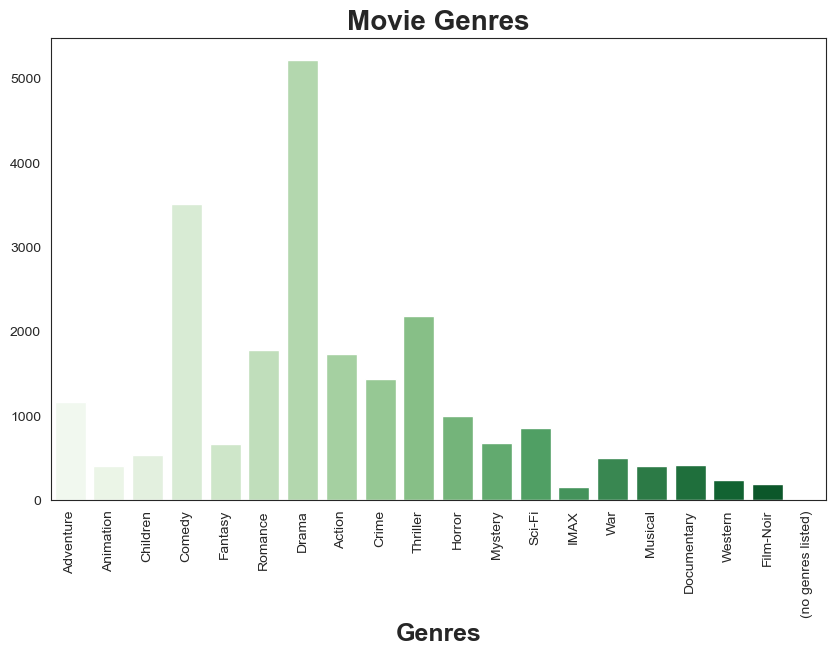

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(x=genres.index, y=genres.values, palette='Greens')
plt.xlabel('Genres', fontsize=18, weight='bold')
plt.title('Movie Genres', fontsize=20, weight='bold')
plt.xticks(rotation=90)
plt.show()

In [19]:
# movie with the highest number of ratng 
count_ratings.sort_values('num_of_ratings', ascending=False).merge(movies_df, on='movieId').head()

,movieId,mean_rating,num_of_ratings,title,genres
0,296,4.160000,325,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,356,4.138264,311,Forrest Gump (1994),Comedy|Drama|Romance|War
2,318,4.454545,308,"Shawshank Redemption, The (1994)",Crime|Drama
3,480,3.659864,294,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
4,593,4.194828,290,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller


In [20]:
# movies with the highest average rating
count_ratings.sort_values('mean_rating', ascending=False).merge(movies_df, on='movieId').head()

,movieId,mean_rating,num_of_ratings,title,genres
0,465,5.0,1,Heaven & Earth (1993),Action|Drama|War
1,111387,5.0,1,Palo Alto (2013),Drama
2,1757,5.0,1,Fallen Angels (Duo luo tian shi) (1995),Drama|Romance
3,5003,5.0,1,"Nine Lives of Fritz the Cat, The (1974)",Animation
4,5007,5.0,1,Topkapi (1964),Adventure|Comedy|Thriller


Notice how the highest rated movies have only been rated once. This is not fair on the averaging

WE will use a better approach for averaging all the ratings per movies in our dataset

**Bayesian Average:**

The Bayesian average is defined as:
- bayesian_Avg = $\frac {C \times m + \sum reviews} {C + N}$

Where:
- C is the average rating per movie
- N is the total number of reviews for a movie i
- m is the average rating across all movies

In [21]:
C = count_ratings.num_of_ratings.mean()
m = count_ratings.mean_rating.mean()

print(f'Average rating per movie: {C:.2f}')
print(f'Average rating across all movies: {m:.2f}')

Average rating per movie: 10.20
Average rating across all movies: 3.18


In [22]:
def bayesian_average(ratings):
    bayesian_avg = (C*m + ratings.sum()) / (C + ratings.count())
    return round(bayesian_avg, 2)

In [23]:
bayesian_avg_rating = ratings_df.groupby('movieId')['rating'].aggregate(bayesian_average).reset_index()

In [24]:
bayesian_avg_rating.rename(columns={'rating': 'bay_avg'}, inplace=True)

In [25]:
# joining bayesian average to count_ratings dataset
print(len(count_ratings))
print(len(bayesian_avg_rating))

bay_rating = pd.merge(count_ratings, bayesian_avg_rating, on='movieId')

10325
10325


In [26]:
bay_rating.head()

,movieId,mean_rating,num_of_ratings,bay_avg
0,1,3.907328,232,3.88
1,2,3.353261,92,3.34
2,3,3.189655,58,3.19
3,4,2.818182,11,2.99
4,5,3.250000,62,3.24


In [27]:
bay_ratings = bay_rating[['movieId', 'bay_avg', 'num_of_ratings']]

In [28]:
popularity_data = bay_ratings.merge(movies_df, on='movieId')

In [29]:
popularity_data.head()

,movieId,bay_avg,num_of_ratings,title,genres
0,1,3.88,232,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,3.34,92,Jumanji (1995),Adventure|Children|Fantasy
2,3,3.19,58,Grumpier Old Men (1995),Comedy|Romance
3,4,2.99,11,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,3.24,62,Father of the Bride Part II (1995),Comedy


Create a popularity based recommender system at a genre level. User will input a genre (g), minimum ratings threshold (t) for a movie and no. of recommendations(N) for which it should be recommended top N movies which are most popular within that genre (g) ordered by ratingsin descending order where each movie has at least (t) reviews.

In [30]:
def popularity_recommendation(data, genre, rating_threashold=0, n_recommendations=50):
    # getting data consisting of the specified threshold
    filter_ = data['genres'].str \
    .contains(genre, flags=re.I, regex=True) & (data['bay_avg']>=rating_threashold)
    
    # getting the max threshold (max bayesian average)
    max_rating_threashold = round(data['bay_avg'].max())
    
    # making sure that the user is also aware of the max threshold
    if rating_threashold > max_rating_threashold:
        print('you have exceeded the maximum rating: ', max_rating_threashold)
    else:
        recommendation = data.loc[filter_].sort_values('bay_avg', ascending=False)
        recommendation = recommendation['title'][: n_recommendations].reset_index(drop=True)
        return recommendation

In [31]:
# getting recommendation for movie genre "comedy"
popularity_recommendation(data=popularity_data, genre='comedy', rating_threashold= 3, n_recommendations=10)

0               Monty Python and the Holy Grail (1975)
1                                         Fargo (1996)
2                                  Pulp Fiction (1994)
3           Life Is Beautiful (La Vita è bella) (1997)
4                                  Forrest Gump (1994)
5                           Princess Bride, The (1987)
6                                    Sting, The (1973)
7                                    Annie Hall (1977)
8    Dr. Strangelove or: How I Learned to Stop Worr...
9                Dr. Horrible's Sing-Along Blog (2008)
Name: title, dtype: object

## Collaborative Based Recommendation System

Create a collaborative based recommender system which recommends top N 
movies based on “K” similar users for a target user “u”.

In [32]:
# combining the raating and the movie datasets together
df = pd.merge(movies_df, ratings_df, on='movieId')
agg_df = df.groupby('title')['rating'].agg(['mean', 'count']).reset_index()
agg_df.columns = ['title', 'avg_rating', 'num_of_ratings']
agg_df.head()

,title,avg_rating,num_of_ratings
0,'71 (2014),3.500,1
1,'Hellboy': The Seeds of Creation (2004),3.000,1
2,'Round Midnight (1986),2.500,1
3,'Til There Was You (1997),4.000,3
4,"'burbs, The (1989)",3.125,20


In [33]:
# keep movies with over 100 ratings
agg_df_grt_100 = agg_df.query('num_of_ratings >= 100')
agg_df_grt_100.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 60 to 10204
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           153 non-null    object 
 1   avg_rating      153 non-null    float64
 2   num_of_ratings  153 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 4.8+ KB


checking the most popular movies and their rating

In [34]:
agg_df_grt_100.sort_values('num_of_ratings', ascending=False).head()

,title,avg_rating,num_of_ratings
7323,Pulp Fiction (1994),4.160000,325
3349,Forrest Gump (1994),4.138264,311
8136,"Shawshank Redemption, The (1994)",4.454545,308
4934,Jurassic Park (1993),3.659864,294
8228,"Silence of the Lambs, The (1991)",4.194828,290


To keep only the movies that have 100 or more number of rating, we will merge the agg_df_grt_100 dataset with the df dataset

In [35]:
df_grt100 = pd.merge(df, agg_df_grt_100['title'], on='title', how='inner')
df_grt100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22856 entries, 0 to 22855
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   movieId    22856 non-null  int64  
 1   title      22856 non-null  object 
 2   genres     22856 non-null  object 
 3   userId     22856 non-null  int64  
 4   rating     22856 non-null  float64
 5   timestamp  22856 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 1.0+ MB


In [36]:
print(f"The new rating dataset has {df_grt100['userId'].nunique()} unique users")
print(f"The new rating dataset has {df_grt100['movieId'].nunique()} unique movies")
print(f"The new rating dataset has {df_grt100['rating'].nunique()} unique ratings")
print(f"The unique ratings are: {df_grt100['rating'].sort_values().unique()} ")

The new rating dataset has 653 unique users
The new rating dataset has 153 unique movies
The new rating dataset has 10 unique ratings
The unique ratings are: [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ] 


**Creating a user_item matrix**

In [37]:
user_item = df_grt100.pivot_table(index='userId', columns='movieId', values='rating')

In [38]:
print('shape of user_item matrix', user_item.shape)
user_item.head()

shape of user_item matrix (653, 153)


movieId,1,6,10,17,21,32,34,47,50,95,...,5445,5952,6377,6539,6874,7153,8961,33794,58559,79132
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,4.0,NaN,...,3.5,4.5,NaN,NaN,NaN,4.5,4.0,4.5,NaN,NaN
2,5.0,NaN,NaN,5.0,NaN,3.0,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,5.0,NaN,5.0,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Normailizing the Ratings**

since some users give more ratings than the others, we need to normalise the ratings

In [39]:
user_item_norm = user_item.subtract(user_item.mean(axis=1), axis='rows')
user_item_norm.head()

movieId,1,6,10,17,21,32,34,47,50,95,...,5445,5952,6377,6539,6874,7153,8961,33794,58559,79132
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,0.169231,NaN,0.169231,0.169231,NaN,...,-0.330769,0.669231,NaN,NaN,NaN,0.669231,0.169231,0.669231,NaN,NaN
2,0.8,NaN,NaN,0.8,NaN,-1.200000,NaN,NaN,NaN,-0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,1.285714,NaN,1.285714,NaN,1.285714,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,0.937500,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are two ways to measure similarities. Pearson correlation and cosine similarity are the two widely used methods.

In [40]:
user_similarity = user_item_norm.T.corr()
user_similarity.head()

userId,1,2,3,4,5,6,7,8,9,10,...,659,660,661,662,663,664,665,666,667,668
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,-0.306186,0.614559,0.431124,-0.094491,0.471405,0.153463,0.369274,0.195776,-1.0,...,0.099066,0.375769,0.107583,0.349334,0.410803,-0.505322,0.029258,0.018696,0.144082,0.230468
2,-0.306186,1.000000,0.866025,-1.000000,NaN,NaN,-0.555556,0.577350,0.333333,NaN,...,-1.000000,NaN,0.573539,-0.408248,0.577350,NaN,-0.174078,NaN,-1.000000,0.309359
3,0.614559,0.866025,1.000000,NaN,0.162938,NaN,-0.228587,1.000000,0.391121,-1.0,...,0.345186,0.585540,1.000000,0.000000,0.252050,-0.491398,0.484123,0.336336,0.392989,0.231076
4,0.431124,-1.000000,NaN,1.000000,NaN,NaN,-0.115186,NaN,-0.250000,NaN,...,-0.662266,NaN,-1.000000,0.408248,NaN,NaN,-0.801784,-0.063610,0.965824,0.291551
5,-0.094491,NaN,0.162938,NaN,1.000000,-0.970725,0.077671,NaN,-0.158114,NaN,...,-0.427828,NaN,NaN,0.960769,NaN,-0.548611,0.104257,-0.944911,-0.052658,-0.113529


Let us use a random id to illustrate how to find similar users. Will need to exclude the user id we have picked from the list of users and decide the number of similar users.

In [41]:
# pick user id 1
picked_user_id = 1

# romove picked user ID from the user_similarity list
user_similarity.drop(index=1, inplace=True)

user_similarity.head()

userId,1,2,3,4,5,6,7,8,9,10,...,659,660,661,662,663,664,665,666,667,668
userId,,,,,,,,,,,,,,,,,,,,,
2,-0.306186,1.000000,0.866025,-1.0,NaN,NaN,-0.555556,0.57735,0.333333,NaN,...,-1.000000,NaN,0.573539,-0.408248,0.57735,NaN,-0.174078,NaN,-1.000000,0.309359
3,0.614559,0.866025,1.000000,NaN,0.162938,NaN,-0.228587,1.00000,0.391121,-1.0,...,0.345186,0.58554,1.000000,0.000000,0.25205,-0.491398,0.484123,0.336336,0.392989,0.231076
4,0.431124,-1.000000,NaN,1.0,NaN,NaN,-0.115186,NaN,-0.250000,NaN,...,-0.662266,NaN,-1.000000,0.408248,NaN,NaN,-0.801784,-0.063610,0.965824,0.291551
5,-0.094491,NaN,0.162938,NaN,1.000000,-0.970725,0.077671,NaN,-0.158114,NaN,...,-0.427828,NaN,NaN,0.960769,NaN,-0.548611,0.104257,-0.944911,-0.052658,-0.113529
6,0.471405,NaN,NaN,NaN,-0.970725,1.000000,0.309426,NaN,NaN,NaN,...,0.302614,NaN,NaN,0.132453,NaN,NaN,-0.166667,NaN,1.000000,-0.080930


In the user_similarity matrix that we have created, the values ranges from -1 to 1, where -1 means opposite movie preference and 1 means same movie preference.

n represents the number of top users wee want for the picked user ID


The user-based collaborative filtering makes recommendations based on users with similar tastes, so we need to set a positive threshold. Here we have set user_similarity_thrh to be 0.3, user ID to be 1, and top similar user n to be 10. This means a user must have a Pearson correlation of at least 0.3 to be considered as a similar user.

After setting the number of similar users and similarity threshold, we sort the user similarity value from highest to lowest, then print out the most similar user's ID and the Pearson correlation value.

In [42]:
# number of similar users
n = 10

# user similarity threashold 
'''
this means the user must have a pearson correlation that meets the threshold
we have set

'''
t = 0.3

# get top n similar users
similar_user = user_similarity[user_similarity[picked_user_id] > t][picked_user_id].sort_values(ascending=False)[:n]
similar_user

userId
34     1.000000
154    1.000000
67     1.000000
117    1.000000
533    1.000000
621    0.981981
526    0.966988
103    0.945343
271    0.943300
26     0.940582
Name: 1, dtype: float64

Now we are going to remove the movies watched by the picked user and keep only the movies that have been watched by similar users

In [43]:
# movies watched by picked user
watched_by_user = user_item_norm[user_item_norm.index == picked_user_id].dropna(axis=1, how='all')
watched_by_user

movieId,32,47,50,110,150,161,165,223,260,296,...,4963,4993,4995,5349,5418,5445,5952,7153,8961,33794
userId,,,,,,,,,,,,,,,,,,,,,
1,0.169231,0.169231,0.169231,0.169231,-0.830769,0.169231,-0.830769,0.169231,0.669231,0.169231,...,-0.330769,0.669231,0.169231,-0.830769,0.169231,-0.330769,0.669231,0.669231,0.169231,0.669231


In [44]:
# Now to keep only movies watched by similar users
watched_by_similar_users = user_item_norm[user_item_norm.index.isin(similar_user.index)]
# remove the movies in wich none of the users have watched
watched_by_similar_users.dropna(axis=1, how='all', inplace=True)

In [45]:
# now we are going to remove movies in which the picked user id had watched
user_movies = watched_by_user.columns.values
watched_by_similar_users.drop(user_movies, axis=1, inplace=True, errors='ignore')

In [46]:
# this shows that there are about 71 movies we can recommend to the user of
# interest based on similar users
watched_by_similar_users.shape

(10, 24)

this shows that there are about 24 movies we can recommend to the user of
interest from top 10 similar users

**RECOMMENDING MOVIES**

The recommended movies are determined by the weighted average of user similarity score and movie rating. the movie ratings are weighted by the similarity scores, so the users with higher similarity get higher weights.


In [47]:
'''
This code loops through items and users to get the item score, rank the score
from high to low and pick he top 10 movies to recommend to the selected user
'''

# A dictionar to store item scores
item_score = {}

# loop through items
for i in watched_by_similar_users.columns:
    # get ratings for i
    movie_rating = watched_by_similar_users[i]
    # create a variable to store the score
    total = 0
    # create a variable to store the number of scores
    count = 0
    # loop through similar users
    for u in similar_user.index:
        # if the movie has rating
        if pd.isna(movie_rating[u]) == False:
            # score is the sum of user similarity score multiply by the movie rating
            score = similar_user[u] * movie_rating[u]
            # add the score to the total score for the moview so far
            total += score
            # add 1 to count
            count += 1
    item_score[i] = total / count
    
# convert item_score to a pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['movieId', 'score'])

# sort the movies by score
ranked_item_score = item_score.sort_values('score', ascending=False)


In [48]:
# select top n movies
m = 30
top_movies = ranked_item_score.head(m)
top_movies

,movieId,score
2,17,1.785648
1,6,0.971650
7,750,0.637500
20,2987,0.548673
23,6874,0.490990
21,2997,0.446982
17,2706,0.386795
19,2918,0.193398
13,1610,0.078382
6,733,0.000000


In [49]:

# get the movies titles
pd.merge(top_movies, movies_df, on='movieId', how='inner')['title']

0                          Sense and Sensibility (1995)
1                                           Heat (1995)
2     Dr. Strangelove or: How I Learned to Stop Worr...
3                       Who Framed Roger Rabbit? (1988)
4                              Kill Bill: Vol. 1 (2003)
5                           Being John Malkovich (1999)
6                                   American Pie (1999)
7                       Ferris Bueller's Day Off (1986)
8                      Hunt for Red October, The (1990)
9                                      Rock, The (1996)
10           Willy Wonka & the Chocolate Factory (1971)
11                    E.T. the Extra-Terrestrial (1982)
12         Austin Powers: The Spy Who Shagged Me (1999)
13                            Fifth Element, The (1997)
14                                     Toy Story (1995)
15                           In the Line of Fire (1993)
16                                       Memento (2000)
17                                 Bug's Life, A

**Puting all of the codes that help us make recommendation in one functon**

In [52]:
def recommender(data, user, k, threshold=0.3, N=10):
    """
    Args:
        data: is the data that will be processed for recommen
        threshold: Pearson's correlation value ranging from 0 to 1
        user: takes user ID
        k: number of similar user you want to include
        N: number of recommended movies
    
    """
#     creating a user item matrix
    user_item = pd.pivot_table(data=data, index='userId', columns='movieId', values='rating')
    # creating a fuction that helps us normalize the ratings
    user_item_norm = user_item.subtract(user_item.mean(axis=1), axis='rows')
    # creating a user similarity matrix with Pearsons correlation
    user_similarity = user_item_norm.T.corr()
    
    picked_user_id = user
    # remove picked user id from the list
    user_similarity.drop(index=picked_user_id, inplace=True)

    
    #  movies that the target user has eatched
    picked_userid_watched = user_item_norm[user_item_norm.index == picked_user_id].dropna(axis=1, how='all')
    
    
    # get top n similarity users
    similar_user = user_similarity[user_similarity[picked_user_id]>threshold][picked_user_id]
    # sorting the 'n' number of users by the pearson correlation
    similar_user = similar_user.sort_values(ascending=False)[:k]
    #print(f"The similar users for user {picked_user_id} are: ")
    #print(similar_user)
    watched_by_user = user_item_norm[user_item_norm.index == picked_user_id].dropna(axis=1, how='all')
    watched_by_similar_users = user_item_norm[user_item_norm.index.isin(similar_user.index)].dropna(axis=1, how='all')
    watched_by_similar_users.drop(watched_by_user.columns, axis=1, inplace= True, errors='ignore')
    # A dictionary to store item score
    item_score = {}
    # looping through items
    for i in watched_by_similar_users.columns:
        # get the ratings for movie i
        movie_rating = watched_by_similar_users[i]
        # create variable to store the score
        total = 0
        # create variable to store the number of scores
        count = 0
        # loop through the similar users
        for u in watched_by_similar_users.index:
            # if the movie has rating
            if pd.isna(movie_rating[u]) == False:
                # score is the sum of user similarity score multiplied by the movie rating
                score = similar_user[u] * movie_rating[u]
                # Add the score to the total score for the movie so far
                total += score
                # add 1 to the count
                count += 1
        item_score[i] = total /count

    item_score = pd.DataFrame(item_score.items(), columns=['movieId', 'movie_score'])
    ranked_item_score = item_score.sort_values('movie_score', ascending=False)
    # select top m movies
    
    recomendations = pd.merge(ranked_item_score.head(N), movies_df, how='inner', on='movieId')
    
    #return recomendations.title
    for i in recomendations.title.values:
        print(i)

In [61]:
# getting recommendations for user 1 with 10 most similar users
recommender(df_grt100, threshold=0.3, k=10, user=1)

Sense and Sensibility (1995)
Heat (1995)
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
Who Framed Roger Rabbit? (1988)
Kill Bill: Vol. 1 (2003)
Being John Malkovich (1999)
American Pie (1999)
Ferris Bueller's Day Off (1986)
Hunt for Red October, The (1990)
Rock, The (1996)


# Content based Recommendation

The collaborative filtering method of recommendation relies on user-item matrix. New users or items get excluded from the recommendation system. Content base filtering is a way to handle this draw back in collaborative recommendation system. In content based filtering, items are recommended base on attributes such as genre, director, actors, and other keywords related to its plot.

In [67]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [63]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


In [64]:
movies_df['genres'] = movies_df['genres'].apply(lambda x: x.split("|"))
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


Now we will make columns for all genres and fill their values with 0 or 1. 1 indicates that the genre is present for that row and zero indicates otherwise.

In [65]:
genres = set([g for i in movies_df.genres for g in i])

In [71]:
movies_df.title

0                           Toy Story (1995)
1                             Jumanji (1995)
2                    Grumpier Old Men (1995)
3                   Waiting to Exhale (1995)
4         Father of the Bride Part II (1995)
                        ...                 
10324          Cosmic Scrat-tastrophe (2015)
10325             Le Grand Restaurant (1966)
10326         A Very Murray Christmas (2015)
10327                   The Big Short (2015)
10328    Marco Polo: One Hundred Eyes (2015)
Name: title, Length: 10329, dtype: object

In [72]:
for i in genres:
    movies_df[i] = movies_df.genres.apply(lambda x: int(i in x))

In [73]:
movie_genre = movies_df.drop(['movieId', 'title', 'genres'], axis=1)
movie_genre.head()

,Mystery,Comedy,Documentary,Western,(no genres listed),Thriller,Horror,Action,Romance,Adventure,Fantasy,IMAX,Children,War,Animation,Crime,Musical,Sci-Fi,Film-Noir,Drama
0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [74]:
# all genres are present as features
len(movie_genre.columns)

20

In [75]:
movie_genre.shape

(10329, 20)

using cosine similarity to find similarity between genres

In [76]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_genre, movie_genre)
cosine_sim.shape

(10329, 10329)

In [77]:
cosine_sim

array([[1.        , 0.77459667, 0.31622777, ..., 0.4472136 , 0.        ,
        0.        ],
       [0.77459667, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.31622777, 0.        , 1.        , ..., 0.70710678, 0.        ,
        0.        ],
       ...,
       [0.4472136 , 0.        , 0.70710678, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [78]:
cosine_sim[0]

array([1.        , 0.77459667, 0.31622777, ..., 0.4472136 , 0.        ,
       0.        ])

After passing the movie_genre dataframe into the cosine_similarity() function, we get a cosine similarity with shape (number_of_movies, number_of_movie)

The matrix is populated with values between 0 and 1 which represent the degree of similarity between movies along x and y axes.

**CREATING A MOVIE FINDER FUNCTION**

If we want to get recommendations for movies that are similar to Avatar,  we need to know the exact title of a movie in our dataset. In our dataset, Avatar is actually named as 'Avatar (2009)'. In any case that the movie title spelled wrongly, or we forgot to add the release year, our recommender system will not be able to identify which movies we are interested in.

TO make our recommender more user-friendly, we can use a Python package called fuzzywuzzy. which will find the most similar title to the string you pass in.

In [79]:
from fuzzywuzzy import process

In [80]:
def title_finder(title):
    all_titles = movies_df['title'].tolist()
    closest_match = process.extractOne(title, all_titles)
    return closest_match[0]

In [83]:
# if i try to find a title of a movie
title = title_finder('spiderman')
title

'Spider-Man (2002)'

In [84]:
# we are going to create a movie index finder here
movie_indexer = pd.Series(movies_df.title.index, index=movies_df.title)
movie_indexer.head()

title
Toy Story (1995)                      0
Jumanji (1995)                        1
Grumpier Old Men (1995)               2
Waiting to Exhale (1995)              3
Father of the Bride Part II (1995)    4
dtype: int64

In [85]:

indx = movie_indexer[title]
print(f'the index for the movie {title} is: {indx}')

the index for the movie Spider-Man (2002) is: 4108


In [86]:
# now let us get the top 10 movies similar to Spider-Man (2002) 
similar_movies = sorted(list(enumerate(cosine_sim[indx])), key=lambda x:  x[1], reverse=True)

# removig already watched movie
filtered = []
for i in similar_movies:
    if i[0] != indx:
        filtered.append(i)
        
filtered[:5]

[(426, 1.0), (646, 1.0), (690, 1.0), (914, 1.0), (916, 1.0)]

In [88]:
# getting top n similar movies
n = 20
top_similar_movies = filtered[1: n+1]
top_similar_movies = [i[0] for i in top_similar_movies]
top_similar_movies

[646,
 690,
 914,
 916,
 1102,
 1115,
 1243,
 1271,
 2329,
 2876,
 3632,
 4059,
 4680,
 5400,
 5732,
 6662,
 6684,
 7833,
 7845,
 8033]

In [89]:
print(f'Because you wantched {title}:')
print()
for i in movies_df.title.iloc[top_similar_movies]:
    print(i)

Because you wantched Spider-Man (2002):

Independence Day (a.k.a. ID4) (1996)
Escape from L.A. (1996)
Abyss, The (1989)
Escape from New York (1981)
Star Trek: First Contact (1996)
Star Trek II: The Wrath of Khan (1982)
Lost World: Jurassic Park, The (1997)
Spawn (1997)
Total Recall (1990)
Moonraker (1979)
Jurassic Park III (2001)
Clockstoppers (2002)
X2: X-Men United (2003)
You Only Live Twice (1967)
I, Robot (2004)
War of the Worlds (2005)
Stealth (2005)
Death Race (2008)
Babylon A.D. (2008)
Street Fighter: The Legend of Chun-Li (2009)


**Now let us put all of this in a codes in one function**


In [90]:
def recommender(title_string, n_recommendation=10):
    """
    A content based recommender.
    
    Args:
        title_string: movie title 
        n_recommendation: number of recommendations to display
    """
    # using the title finder to get correct match for title
    title = title_finder(title_string)
    
    # getting the index of the title
    indx = movie_indexer[title]
    
    # finding movies that are similar to the watched movie
    similar_movies = sorted(list(enumerate(cosine_sim[indx])), key=lambda x:x[1], reverse=True)
    
    # romving the already watched movie from the list
    filtered = []
    for i in similar_movies:
        if i[0] != indx:
            filtered.append(i)
    
    # getting and displaying the top N recommended movies
    top_similar_movies = [i[0] for i in filtered]
    top_similar_movies = top_similar_movies[1: n_recommendation+1]
    top_similar_movies = movies_df['title'][top_similar_movies]
    print(f"Because you watched {title}: ")
    print()
    for i in top_similar_movies:
        print(i)

In [91]:
# getting recommedations for the movie titled "Spawn (1997)"
# by default, number of recommended movies are 10
# user can also specify number of movies
recommender('spawn')

Because you watched Spawn (1997): 

Independence Day (a.k.a. ID4) (1996)
Escape from L.A. (1996)
Abyss, The (1989)
Escape from New York (1981)
Star Trek: First Contact (1996)
Star Trek II: The Wrath of Khan (1982)
Lost World: Jurassic Park, The (1997)
Total Recall (1990)
Moonraker (1979)
Jurassic Park III (2001)
